# RBA SOMP Forecasts

## Set-up

In [1]:
# system imports
import io
from pathlib import Path
from typing import Any, TypeAlias, cast

# analytic imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotting import clear_chart_dir, finalise_plot, set_chart_dir

In [2]:
# local imports
import common
import rba_data_capture
import utility
from abs_data_capture import (
    AbsLandingPage,
    AbsSelectInput,
    AbsSelectionDict,
    get_multi_series,
)

In [3]:
# plotting constants
CHART_DIR = "./CHARTS/SOMP/"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
plt.style.use("fivethirtyeight")
SHOW = False

## Collect and reorganise SOMP data

### Typing information

In [4]:
# Note: use NewType in the future when moved to Python 3.12

# dict holds data by report dates
# rows in df are subject domains columns are projection dates
DateSompType: TypeAlias = dict[str, pd.DataFrame]

# dict holds data by subject domain
# rows in df are projection dates, columns are report dates
DomainSompType: TypeAlias = dict[str, pd.DataFrame]

### Get raw SOMP tables

In [5]:
# Note: inclusive search terms:
START_YEAR = 2019
STOP_YEAR = 2024  # - this will need updating from year to year

In [6]:
def data_cleaning(frame: pd.DataFrame) -> pd.DataFrame:
    """Preliminary data cleaning for the raw SOMP
    data captured from the RBA website."""

    for col in frame.columns:

        # convert text fractions to decimals
        frame[col] = (
            frame[col]
            .astype(str)
            .str.replace("¼", ".25")
            .str.replace("½", ".5")
            .str.replace("¾", ".75")
            .str.replace("−", "-")
        )

        # make to NaN all non-numeric data
        frame[col] = pd.to_numeric(frame[col], errors="coerce")

    # delete all-NaN rows - Needed for Feb 24 report
    frame = frame = frame.dropna(how="all", axis="index")

    # remove odd footnotes from index introduced in Feb 2024
    # and standardize the case used in the index
    # (because of case mismatch before and after Feb 2024)
    frame.index = frame.index.str.replace(r"\([a-z]\)$", "", regex=True).str.title()

    return frame

In [7]:
def collect_somp_data() -> DateSompType:
    """Collect raw SOMP data, as presented in these SOMP
    reports. Returns one table for each report in a dict."""

    cache_dir = "./RBA_SOMP_CACHE"
    cache = Path(cache_dir)
    cache.mkdir(parents=True, exist_ok=True)
    q_start = {"feb": 1, "may": 2, "aug": 3, "nov": 4}

    pool: DateSompType = {}
    for year in range(START_YEAR, STOP_YEAR + 1):
        for qtr, q_number in q_start.items():

            # get URL
            url = (
                (
                    "https://www.rba.gov.au/publications"
                    f"/smp/{year}/{qtr}/forecasts.html"
                )
                if year < 2024
                else (
                    # Change of RBA data location in Feb 2024 ...
                    "https://www.rba.gov.au/publications"
                    f"/smp/{year}/{qtr}/outlook.html"
                )
            )

            # get the HTML text found at URL
            try:
                file = common.get_file(url, cache)
            except common.HttpError:
                print(f"Did not get: {year}-{qtr}")
                continue

            # get and clean relevant table from the HTML
            frame_list = pd.read_html(cast(str, io.BytesIO(file)), index_col=0)
            relevant_table = 0
            frame = data_cleaning(frame_list[relevant_table])

            # save the table into a dict
            index = f"{year}-Q{q_number}"
            pool[index] = frame

    return pool

In [8]:
raw_somp = collect_somp_data()

Did not get: 2024-may
Did not get: 2024-aug
Did not get: 2024-nov


### Reorganise SOMP data

In [9]:
def reorganise_somp(inputs: dict[str, pd.DataFrame]) -> DomainSompType:
    """Reorganise the SOMP data
    from tables by date to tables by domain."""

    ue = "Unemployment Rate"
    pool: DomainSompType = {}
    for index, frame in inputs.items():
        for item in frame.index:
            if item[0] == "(":
                continue  # ignore footnotes
            row = frame.loc[item]
            row.name = index
            item_adj = ue if ue in item else item
            if item_adj not in pool:
                pool[item_adj] = pd.DataFrame(row)
            else:
                pool[item_adj] = pd.concat([pool[item_adj], pd.DataFrame(row)], axis=1)

    for table in pool.values():
        table.columns = pd.PeriodIndex(table.columns, freq="Q-NOV")
        table.index = pd.PeriodIndex(table.index, freq="Q-DEC")

    return pool

In [10]:
somp: DomainSompType = reorganise_somp(raw_somp)
somp.keys()

dict_keys(['Gross Domestic Product', 'Household Consumption', 'Dwelling Investment', 'Business Investment', 'Public Demand', 'Gross National Expenditure', 'Imports', 'Exports', 'Real Household Disposable Income', 'Terms Of Trade', 'Major Trading Partner (Export-Weighted) Gdp', 'Unemployment Rate', 'Employment', 'Wage Price Index', 'Nominal (Non-Farm) Average Earnings Per Hour', 'Trimmed Mean Inflation', 'Consumer Price Index', 'Hours-Based Underutilisation Rate (Quarterly, %)', 'Nominal Average Earnings Per Hour (Non-Farm)', 'Cash Rate (%)', 'Trade-Weighted Index (Index)', 'Brent Crude Oil Price (Us$/Bbl)', 'Estimated Resident Population', 'Labour Productivity', 'Household Savings Rate (%)', 'Real Wage Price Index', 'Real Average Earnings Per Hour (Non-Farm)'])

## Plotting

### Annual Growth Measures

In [11]:
growth_measures: AbsSelectionDict = {
    "Gross Domestic Product": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="national-accounts",
            topic="australian-national-accounts-national-income-expenditure-and-product",
        ),
        table="1",
        orig_sa="SA",
        search1="Chain volume measures ;",
        search2="Gross domestic product:",
        abbr="not used",
        calc_growth=True,
    ),
    "Household Consumption": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="national-accounts",
            topic="australian-national-accounts-national-income-expenditure-and-product",
        ),
        table="8",
        orig_sa="SA",
        search1="Chain volume measures ;",
        search2="FINAL CONSUMPTION EXPENDITURE:",
        abbr="not used",
        calc_growth=True,
    ),
    "Dwelling Investment": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="national-accounts",
            topic="australian-national-accounts-national-income-expenditure-and-product",
        ),
        table="2",
        orig_sa="SA",
        search1="Private ;  Gross fixed capital formation - Dwellings - Total ;",
        search2="Private ;  Gross fixed capital formation - Dwellings - Total ;",
        abbr="not used",
        calc_growth=True,
    ),
    "Gross National Expenditure": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="national-accounts",
            topic="australian-national-accounts-national-income-expenditure-and-product",
        ),
        table="2",
        orig_sa="SA",
        search1="Gross national expenditure ;",
        search2="Gross national expenditure ;",
        abbr="not used",
        calc_growth=True,
    ),
    "Imports": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="national-accounts",
            topic="australian-national-accounts-national-income-expenditure-and-product",
        ),
        table="2",
        orig_sa="SA",
        search1="Imports of goods and services ;",
        search2="Imports of goods and services ;",
        abbr="not used",
        calc_growth=True,
    ),
    "Exports": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="national-accounts",
            topic="australian-national-accounts-national-income-expenditure-and-product",
        ),
        table="2",
        orig_sa="SA",
        search1="Exports of goods and services ;",
        search2="Exports of goods and services ;",
        abbr="not used",
        calc_growth=True,
    ),
    "Trimmed Mean Inflation": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="price-indexes-and-inflation",
            topic="consumer-price-index-australia",
        ),
        table="8",
        orig_sa="SA",
        search1="Percentage Change from Corresponding Quarter of Previous Year",
        search2="Trimmed Mean ;  Australia ;",
        abbr="not used",
        calc_growth=False,
    ),
    "Consumer Price Index": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="price-indexes-and-inflation",
            topic="consumer-price-index-australia",
        ),
        table="2",
        orig_sa="Orig",
        search1="Percentage Change from Corresponding Quarter of Previous Year",
        search2="All groups CPI ;  Australia ;",
        abbr="not used",
        calc_growth=False,
    ),
    "Wage Price Index": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="price-indexes-and-inflation",
            topic="wage-price-index-australia",
        ),
        table="1",
        orig_sa="SA",
        search1="Percentage Change From Corresponding Quarter of Previous Year",
        search2="Australia ;  Total hourly rates of pay excluding bonuses ;  "
        + "Private and Public ;  All industries ;",
        abbr="not used",
        calc_growth=False,
    ),
    "Estimated Resident Population": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="people",
            parent_topic="population",
            topic="national-state-and-territory-population",
        ),
        table="1",
        orig_sa="Orig",
        search1="Percentage ERP Change Over Previous Year ;  Australia ;",
        search2="Percentage ERP Change Over Previous Year ;  Australia ;",
        abbr="not used",
        calc_growth=False,
    ),
    # "Business Investment": (
    #
    #    # -- Needs work - ‘Business investment’ and ‘Public demand’ have been
    #    # adjusted to exclude the effects of net sales of existing capital
    #    # assets between the private and other (public and external) sectors.
    #
    #    "5206",
    #    "2",
    #    "SA",
    #    "Private ;  Gross fixed capital formation ;",
    #    "Private ;  Gross fixed capital formation ;",
    #    True,
    # ),
    # "Public Demand": (
    #
    #    # Needs work - see above
    #
    #    "5206",
    #    "24",
    #    "SA",
    #    "Public ;  Final demand: Chain volume measures ;",
    #    "Public ;  Final demand: Chain volume measures ;",
    #    True,
    # ),
    # - Series stops with 23Q4 ... Replaced by
    #  'Real Average Earnings Per Hour (Non-Farm)'
    #   in 24Q1 SOMP
    # "Nominal (Non-Farm) Average Earnings Per Hour": (
    #    "5206",
    #    "24",
    #    "SA",
    #    "Current prices ;",
    #    "Non-farm compensation of employees per hour:",
    #    True,
    # ),
}

### Utility functions

In [12]:
def plot_somp(
    ax: mpl.axes.Axes,
    somp_df: pd.DataFrame,
    last_n: int = 0,
) -> None:
    """Add the quarterly SOMP forecasts to a plot."""

    df = somp_df.copy()  # non destructive
    df = df[df.columns[-last_n:]] if last_n else df

    n_colours = len(df.columns)
    gradient = np.linspace(0, 1, n_colours)
    cmap = cmap = plt.get_cmap("viridis")
    colors = (
        cmap(gradient)
        if last_n == 0 or last_n > 2
        else ("cornflowerblue", "darkorange")
    )
    xy = set()
    last = df.columns[-1]

    for col, color in zip(df.columns, colors):
        s = df[col].astype(float).dropna()  # kludge
        if s.notna().sum() == 0 or s.index[0].year < START_YEAR:
            continue
        color = "darkred" if col == last else color
        s.plot(ax=ax, lw=1.5, c=color, label=str(col)[2:])
        x, y = s.index[-1], s.iloc[-1]
        # let's minimise over-plotting of text
        va = "bottom" if (x, y) not in xy else "top"
        ax.text(x=x, y=y, s=str(col)[2:], fontsize=6, va=va)
        xy.add((x, y))

In [13]:
def plot_ss(series: pd.Series, somp_df: pd.DataFrame, n: int) -> mpl.axes.Axes:
    """Plot original series and SOMP forecasts.
    Creates and returns the Axes."""

    if series.index.freqstr[0] == "M":
        somp_df = utility.qtly_to_monthly(somp_df, interpolate=False, dropna=False)
        somp_df.index = somp_df.index - 1  # month

    _, ax = plt.subplots()
    plot_somp(ax, somp_df, last_n=n)
    series[series.index.year >= START_YEAR - 1].plot(
        ax=ax, lw=3.5, color="red", alpha=0.65, label="ABS"
    )

    return ax

In [14]:
def plot_title(name: str) -> str:
    """Correctly label modeling assumptions and memo items."""

    title = f"{name} (with RBA SOMP forecasts)"
    if name in (
        "Cash Rate (%)",
        "Trade-Weighted Index (Index)",
        "Brent Crude Oil Price (Us$/Bbl)",
        "Estimated Resident Population",
    ):
        title = title.replace("forecasts", "assumptions")
    if name in (
        "Labour Productivity",
        "Household Savings Rate (%)",
        "Real Wage Price Index",
        "Real Average Earnings Per Hour (Non-Farm)",
    ):
        title = title.replace("forecasts", "memo items")

    fold_line_threshold = 55
    if len(title) > fold_line_threshold:
        # replace the last occurrence
        old = " ("
        new = "\n("
        title = (title[::-1].replace(old[::-1], new[::-1], 1))[::-1]

    return title

In [15]:
def plot_twice(
    series: pd.Series,
    somp_df: pd.DataFrame,
    name: str,
    **kwargs: Any,
) -> None:
    """produce two plots."""

    recency = (0, 2)
    tags = ("", "-last2")
    extra_tag = kwargs.get("tag", "")
    if "tag" in kwargs:
        del kwargs["tag"]

    title = plot_title(name)
    core_args = {
        "title": title,
        "y0": True,
        "legend": {"ncols": 1, "loc": "center left", "fontsize": "xx-small"},
        "show": SHOW,
    }
    for last_n, tag in zip(recency, tags):
        ax = plot_ss(series, somp_df, last_n)
        finalise_plot(
            ax,
            tag=f"{extra_tag}{tag}",
            **kwargs,
            **core_args,
        )

In [16]:
def plot_annual_growth(
    abs_wanted: AbsSelectionDict,
    somp_data: DomainSompType,
    ylabel: str = "Growth (per cent per year)",
) -> None:
    """Produce a plot for the selected input."""

    abs_dataset = get_multi_series(abs_wanted)

    for name, abs_series in abs_dataset.items():
        series = abs_series.series
        plot_twice(
            series,
            somp_data[name],
            name,
            ylabel=ylabel,
            lfooter=f"Australia. ABS {abs_series.orig_sa} series.",
            rfooter=f"RBA SOMP. ABS {abs_series.cat_id}-{abs_series.table}.",
        )

In [17]:
plot_annual_growth(growth_measures, somp)

### Real household disposable income
See table H from the RBA Statistical Tables: 'Real household disposable income' is household disposable income after the deduction of interest payments, deflated by the implicit price deflator for household consumption expenditure; includes income from unincorporated enterprises.

In [18]:
di_measures: AbsSelectionDict = {
    "Disposable income": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="national-accounts",
            topic="australian-national-accounts-national-income-expenditure-and-product",
        ),
        table="20",
        orig_sa="SA",
        search1="GROSS DISPOSABLE INCOME ;",
        search2="GROSS DISPOSABLE INCOME ;",
        abbr="not used",
        calc_growth=False,
    ),
    "HFCE deflator": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="national-accounts",
            topic="australian-national-accounts-national-income-expenditure-and-product",
        ),
        table="5",
        orig_sa="SA",
        search1=" ",
        search2="Households ;  Final consumption expenditure ;",
        abbr="not used",
        calc_growth=False,
    ),
}

In [19]:
def plot_di(somp_data: DomainSompType):
    """Plot disposable income"""

    name = "Real Household Disposable Income"
    di_data = get_multi_series(di_measures)
    deflator = di_data["HFCE deflator"].series / 100.0
    rhdi = di_data["Disposable income"].series / deflator
    series = (rhdi / rhdi.shift(4) - 1) * 100.0
    tables = ", ".join([f"{x.cat_id}-{x.table}" for x in di_data.values()])

    plot_twice(
        series,
        somp_data[name],
        name,
        ylabel="Growth (per cent per year)",
        lfooter=f"Australia. ABS {di_data['HFCE deflator'].orig_sa} series.",
        rfooter=f"RBA SOMP. ABS {tables}.",
    )

In [20]:
plot_di(somp)

### Unemployment rate

Note: The UE rate in the SMOP is a quarterly figure, which we are plotting against a monthly ABS series. This is not quite apples and oranges.

In [21]:
def plot_ue(somp_data: DomainSompType):
    """Plot the SOMP UE forecasts."""

    ue_text = "Unemployment Rate"
    ue_measure = {
        ue_text: AbsSelectInput(
            landing_page=AbsLandingPage(
                theme="labour",
                parent_topic="employment-and-unemployment",
                topic="labour-force-australia",
            ),
            table="1",
            orig_sa="SA",
            search1="Unemployment rate ;",
            search2="Persons",
            abbr="not used",
            calc_growth=False,
        ),
    }

    somp_df = somp_data[ue_text]
    ue_data = get_multi_series(ue_measure)
    for period in ("monthly", "quarterly"):
        series = ue_data[ue_text].series.copy()

        if period == "quarterly":
            series = utility.monthly_to_qtly(series)

        plot_twice(
            series,
            somp_df,
            ue_text,
            ylabel="UE Rate (per cent)",
            lfooter=f"Australia. ABS {ue_data[ue_text].orig_sa} series.",
            rfooter=f"RBA SOMP. ABS {ue_data[ue_text].cat_id}-{ue_data[ue_text].table}.",
            tag=period,
        )

In [22]:
plot_ue(somp)

### Number in Employment

This looks like a quarterly average in SOMP

In [23]:
# Force E data to be quarterly
E_QUARTERLY = False

In [24]:
def plot_employment(somp_data: DomainSompType):
    """Plot the SOMP Employment forecasts."""

    e_text = "Employment"
    e_measure = {
        e_text: AbsSelectInput(
            landing_page=AbsLandingPage(
                theme="labour",
                parent_topic="employment-and-unemployment",
                topic="labour-force-australia",
            ),
            table="1",
            orig_sa="SA",
            search1="Employed total ;",
            search2="Persons",
            abbr="not used",
            calc_growth=True,
        ),
    }

    somp_df = somp_data[e_text]
    e_data = get_multi_series(e_measure)
    for period in ("monthly", "quarterly"):
        series = e_data[e_text].series.copy()
        if period == "quarterly":
            series = utility.monthly_to_qtly(series)

    plot_twice(
        series,
        somp_df,
        e_text,
        ylabel="Growth (per cent per year)",
        lfooter=f"Australia. ABS {e_data[e_text].orig_sa} series.",
        rfooter=f"RBA SOMP. ABS {e_data[e_text].cat_id}-{e_data[e_text].table}.",
        tag=period,
    )

In [25]:
plot_employment(somp)

### Labour productivity

In [26]:
lp_measures = {
    "Gross Domestic Product": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="national-accounts",
            topic="australian-national-accounts-national-income-expenditure-and-product",
        ),
        table="1",
        orig_sa="SA",
        search1="Chain volume measures ;",
        search2="Gross domestic product:",
        abbr="not used",
        calc_growth=False,
    ),
    "Hours Worked": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="labour",
            parent_topic="labour-accounts",
            topic="labour-account-australia",
        ),
        table="1",
        orig_sa="SA",
        search1="Volume; Labour Account hours actually worked in all jobs ;  Australia ;  Total all industries ;",
        search2=" ",
        abbr="not used",
        calc_growth=False,
    ),
}

In [27]:
def plot_labour_productivity() -> None:
    """Produce a labour productivity chart."""

    lp_name = "Labour Productivity"
    lp_data = get_multi_series(lp_measures)
    gdp_units = lp_data["Gross Domestic Product"].unit
    hours_units = lp_data["Hours Worked"].unit
    hours_sa = lp_data["Hours Worked"].orig_sa
    print(f"{gdp_units=} {hours_units=} {hours_sa=}")  # used in next line of code
    gdp = lp_data["Gross Domestic Product"].series * 1000  # equate units
    hours = lp_data["Hours Worked"].series
    series = (gdp / hours).dropna()
    series = (series / series.shift(4) - 1) * 100  # growth
    tables = ", ".join([f"{x.cat_id}-{x.table}" for x in lp_data.values()])

    somp_df = somp[lp_name]  # somp_data

    plot_twice(
        series,
        somp_df,
        lp_name,
        ylabel="Growth (per cent per year)",
        lfooter=f"Australia. ABS {hours_sa} series. Lab. Prod. = GDP / Hours-worked",
        rfooter=f"RBA SOMP. ABS {tables}.",
    )

In [28]:
plot_labour_productivity()

gdp_units='$ Millions' hours_units='Thousand Hours' hours_sa='SA'


### Trimmed mean (monthly and quarterly)

In [29]:
def trimmed_mean():
    """Plot latest SOMP forecast against Q & M trimmed mean."""

    # TM data
    tm_inputs: AbsSelectionDict = {
        "Qrtly CPI Trimmed Mean": AbsSelectInput(
            landing_page=AbsLandingPage(
                theme="economy",
                parent_topic="price-indexes-and-inflation",
                topic="consumer-price-index-australia",
            ),
            table="8",
            orig_sa="SA",
            search1="Percentage Change from Corresponding Quarter of Previous Year",
            search2="Trimmed Mean ;  Australia",
            abbr="Q-CPI-TM",
            calc_growth=False,
        ),
        "Monthly CPI Trimmed Mean": AbsSelectInput(
            landing_page=AbsLandingPage(
                theme="economy",
                parent_topic="price-indexes-and-inflation",
                topic="monthly-consumer-price-index-indicator",
            ),
            table="1",
            orig_sa="Orig",
            search1="Percentage Change from Corresponding Month of Previous Year",
            search2="Annual Trimmed Mean ;  Australia ;",
            abbr="M-CPI-TM",
            calc_growth=False,
        ),
    }

    tm_data = get_multi_series(tm_inputs)
    tables = ", ".join([f"{x.cat_id}-{x.table}" for x in tm_data.values()])
    combined = pd.DataFrame()
    for key in tm_data:
        if tm_data[key].series.index.freqstr[0] == "Q":
            tm_data[key].series = utility.qtly_to_monthly(
                tm_data[key].series, interpolate=False, dropna=False
            )
        combined = pd.concat([combined, pd.DataFrame(tm_data[key].series)], axis=0)
    combined = combined[combined.index.year >= 2019].dropna(how="all")
    combined.columns = [f"{x} - {tm_inputs[x].orig_sa}" for x in tm_inputs]

    # get latest SOMP
    name = "Trimmed Mean Inflation"
    forecast = utility.qtly_to_monthly(
        somp[name].iloc[:, -1], interpolate=False, dropna=False
    ).dropna()
    forecast.name = f"{forecast.name} SOMP"

    # plot
    target = {
        "ymin": 2,
        "ymax": 3,
        "color": "#dddddd",
        "label": "2-3% annual inflation target",
        "zorder": -1,
    }
    ax = combined.plot(color=("blue", "orange"), lw=2)
    forecast.plot(ax=ax, lw=0.75, color="darkred")
    finalise_plot(
        ax,
        title="Trimmed Mean CPI (Q/M): with latest SOMP forecast",
        ylabel="Growth (per cent per year)",
        rfooter=f"RBA SOMP. ABS {tables}.",
        lfooter=f"Australia. Orig=Original series. SA=Seasonally Adjusted series. ",
        legend={"ncols": 1, "loc": "upper left", "fontsize": "x-small"},
        axhspan=target,
        y0=True,
        show=True,
    )

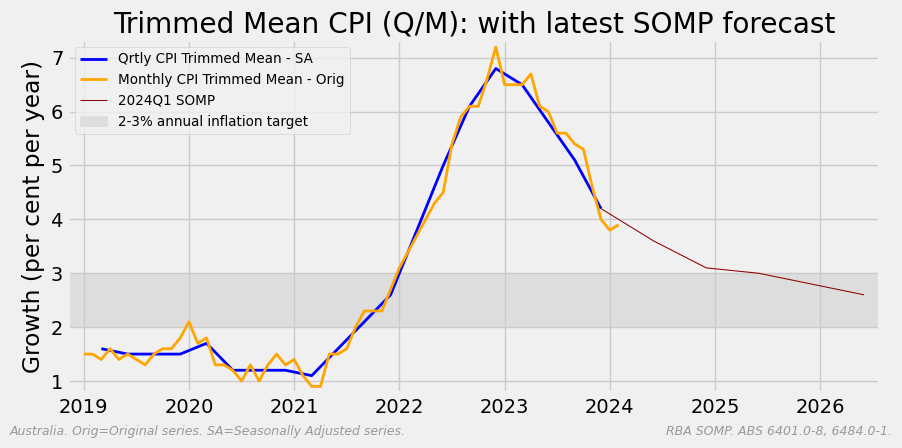

In [30]:
trimmed_mean()

### Cash rate

In [31]:
def plot_cr(somp_data: DomainSompType) -> None:
    """Produce a cash rate chart."""

    # plot the official cash rate history
    a2 = rba_data_capture.get_data("Monetary Policy Changes – A2")
    a2_meta, a2_data = a2 if a2 is not None else (None, None)
    target = "New Cash Rate Target"
    series_id = a2_meta[a2_meta.Title == target].index[0]
    ocr_rba = a2_data[series_id].to_period(freq="M")
    ocr_rba = ocr_rba[~ocr_rba.index.duplicated(keep="last")]
    new_index = pd.period_range(
        start=ocr_rba.index.min(), end=(pd.Timestamp.now().to_period(freq="M"))
    )
    ocr_rba = ocr_rba.reindex(new_index, fill_value=np.nan).ffill()
    ocr_rba = ocr_rba[ocr_rba.index.year >= START_YEAR]

    cr = "Cash Rate (%)"
    plot_twice(
        ocr_rba,
        somp_data[cr],
        cr,
        ylabel=cr,
        lfooter="Australia.",
        rfooter="RBA SOMP.",
    )

In [32]:
plot_cr(somp)

## Finished

In [33]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Mar 29 2024 15:32:41

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy     : 1.26.4
matplotlib: 3.8.3
pandas    : 2.2.1

Watermark: 2.4.3



In [34]:
print("Finished.")

Finished.
